In [14]:
"""
DSS Main Assignment Section 2 - Machine Learning Model - Random Forest Classifier

Date Created: 05/06/2022 1:27pm
Created by: Christian Shackleton

Use data passed from DSS Main Assignment Section 1 - Data Analysis and Exploration, and create a Random Forest
model, with the desired outcome to accurately determine whether a flight will arrive ON_TIME or NOT_ON_TIME.

"""

### Set up enviroment
## Packages Required:
import pandas as pd # Dataframe manipulation
import numpy as np # Data organisation as multidimensional array object with vectorisation and optimisation
import matplotlib.pyplot as plt # Data Visualisation (Graphs, etc.)
import seaborn as sns # Data Visualisation (Graphs, etc.)
# import pickle # Implementing binary protocols for serializing and de-serializing a Python object structure.

from imblearn.over_sampling import SMOTE # For working with unbalanced data
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier # Random Forrest Algorithm
from sklearn.preprocessing import LabelEncoder # Creates numerical lables for classification data
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV # Returns best set of parameters for classifier
from sklearn.model_selection import train_test_split # splits data into test and train sets
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_roc_curve # Result Visualisation

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# Create datafile using Pandas
df1 = pd.read_csv("../datasets/Jan_2019_ontime_modified.csv")

pd.set_option('display.max_columns', None) # to force all columns being shown

df1.head() #Pandas .head() method is used to return top n (5 by default) rows of a data frame or series.


,DAY_OF_WEEK,AIRLINE,Origin_Airport,ORIGIN_cat,Destination_Airport,DEST_cat,DEP_TIME_BLK,ARR_TIME_BLK,DISTANCE_BLK,ARR_DEL15
0,2,Endeavor Air,Tallahassee International Airport,7,Hartsfield-Jackson Atlanta International Airport,12,1500-1559,1600-1659,"(30.0, 224.0]",0.0
1,2,Endeavor Air,Hartsfield-Jackson Atlanta International Airport,12,Fort Smith Regional Airport,4,1900-1959,1900-1959,"(528.0, 640.0]",0.0
2,2,Endeavor Air,Central Illinois Regional Airport at Bloomingt...,7,Hartsfield-Jackson Atlanta International Airport,12,1400-1459,1700-1759,"(528.0, 640.0]",0.0
3,2,Endeavor Air,Detroit Metropolitan Airport,12,Cincinnati/Northern Kentucky International Air...,11,0800-0859,0900-0959,"(224.0, 323.0]",0.0
4,2,Endeavor Air,Indianapolis International Airport,11,Minneapolis-Saint Paul International Airport,12,1100-1159,1100-1159,"(409.0, 528.0]",0.0


In [15]:
#  Of the Data present, we will want to keep the following columns for the model:

# 'DAY_OF_WEEK' because delay could depend on traffic in specific days: change to weekend, holiday, working_day
# 'ORIGIN_cat' Identifies the origin airport Catagory
# 'DEST_cat' Identifies the destination airport Catagory
# 'AIRLINE' because the airline chosen may impact on frequency of delays/cancelations.
# 'DEP_TIME_BLK' because rough time of day is more practical, and will still help indicate busy periods.
# 'ARR_TIME_BLK', (created from ARR_TIME) may help indicate busy periods that could delay arrival.
# 'ARR_DEL15' the key value to consider for training/predicting.
# 'DISTANCE_BLK' (created from DISTANCE) because maybe the distance will have an impact on arrival time accuracy.

# Drop
df1.drop(['Origin_Airport'], inplace=True, axis=1)
df1.drop(['Destination_Airport'], inplace=True, axis=1)

df1.info() # Check that data is suitible for Random Forest Model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DAY_OF_WEEK   150000 non-null  int64  
 1   AIRLINE       150000 non-null  object 
 2   ORIGIN_cat    150000 non-null  int64  
 3   DEST_cat      150000 non-null  int64  
 4   DEP_TIME_BLK  150000 non-null  object 
 5   ARR_TIME_BLK  150000 non-null  object 
 6   DISTANCE_BLK  150000 non-null  object 
 7   ARR_DEL15     150000 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 9.2+ MB


In [16]:
### Preparing Model - Random Forest
## Data Cleaning & Conversion
# Conversion of Numerical data to Catagorical Data for Machine Learning Segment
# label encode ARR_TIME_BLK, DEP_TIME_BLK, DISTANCE_BLK
le = LabelEncoder() # Convert catregorical data to numeric using self assigned numeric values for each class. Also for numeric data

for i in df1.columns:
    df1[i] = le.fit_transform(df1[i]) # Fits and Transforms all data columns to their corresponding encoded numeric values

df1.head()

,DAY_OF_WEEK,AIRLINE,ORIGIN_cat,DEST_cat,DEP_TIME_BLK,ARR_TIME_BLK,DISTANCE_BLK,ARR_DEL15
0,1,6,7,12,10,11,3,0
1,1,6,12,4,14,14,6,0
2,1,6,7,12,9,12,6,0
3,1,6,12,11,3,4,2,0
4,1,6,11,12,6,6,5,0


Correlation of data with 'ARR_DEL15'


<AxesSubplot:>

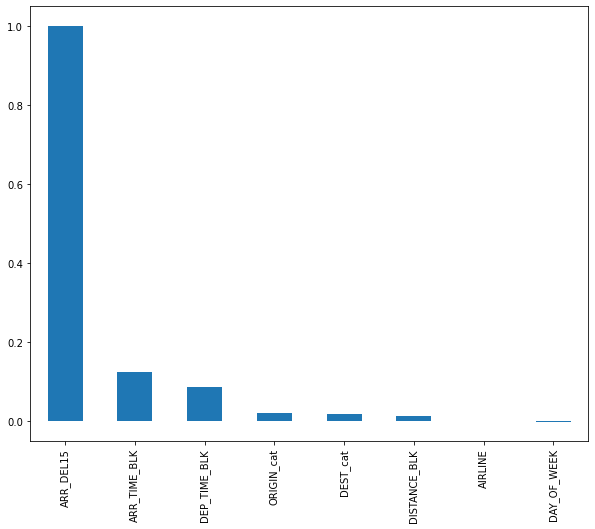

In [17]:
# Check correlation of data with 'ARR_DEL15'
print("Correlation of data with 'ARR_DEL15'")
df1.corrwith(df1['ARR_DEL15']).sort_values(ascending=False).plot(kind='bar',figsize=(10,8))

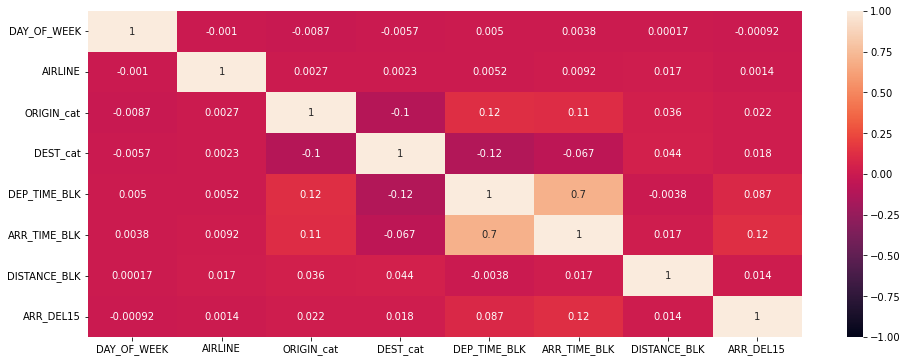

In [18]:
# Show correlation of data with 'ARR_DEL15' as HeatMap
plt.figure(figsize=(16, 6))
ax = sns.heatmap(df1.corr(), vmin=-1, vmax=1, annot=True)

In [19]:
### Start the model
# Set train details
X = df1.drop(['ARR_DEL15'], axis=1).values #we want to predict 'ARR_DEL15' from the given samples so exclude 'ARR_DEL15' from features
y = df1['ARR_DEL15'] #Make 'ARR_DEL15' as your output y vector

y = LabelBinarizer().fit_transform(y) # Ensure that the desired prediction value is binary (1/0, Yes/No)

In [20]:
# Check Balance of the Dataset (i.e. ratio of ON_TIME or NOT_ON_TIME)

# df_y.value_counts() # One line that will output values in 1.0 and 0.0 <- Alternative option to verbose code writen below.

# Verbose Option
df_temp1 = len(df1.loc[(df1['ARR_DEL15'] == 1)])
df_temp0 = len(df1.loc[(df1['ARR_DEL15'] == 0)])

percentage_temp = df_temp1 / len(df1) * 100

text1 = f"Number of Flights that are: NOT_ON_TIME = {df_temp1}."
text2 = f"Number of Flights that are:     On_TIME = {df_temp0}.\n"
text3 = f"This equates to {percentage_temp:.2f}% of all flights.\n"
text4 = f"""A balanced dataset should have this value as 50%. 
If very unbalanced, As our data is significantly imbalanced ({df_temp0} rows for class '0 = on time' and {df_temp1} 
rows for class '1 = delayed'), let's use the SMOTE method (Synthetic Minority Oversampling TEchnique) to generate 
more examples of class 1.
"""
print("Balance of the Dataset (i.e. ratio of ON_TIME or NOT_ON_TIME)\n")
print(text1, text2, text3, text4, sep = '\n')    

Balance of the Dataset (i.e. ratio of ON_TIME or NOT_ON_TIME)

Number of Flights that are: NOT_ON_TIME = 31364.
Number of Flights that are:     On_TIME = 118636.

This equates to 20.91% of all flights.

A balanced dataset should have this value as 50%. 
If very unbalanced, As our data is significantly imbalanced (118636 rows for class '0 = on time' and 31364 
rows for class '1 = delayed'), let's use the SMOTE method (Synthetic Minority Oversampling TEchnique) to generate 
more examples of class 1.



In [21]:
%%time
# Generate rows for minority class as very unbalanced data.
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X, y = smote.fit_resample(X, y)

# df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1) # Alternative Option

CPU times: user 1.68 s, sys: 53 ms, total: 1.74 s
Wall time: 1.92 s


In [22]:
%%time
## Split Data into Test and Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# All decision tree models use float32 (sklearn documentation) as input, preferably with gaussian distribution. 
# So we convert data points into this form (with all features in 0 - 1 range).
X = StandardScaler().fit_transform(X)
X = MinMaxScaler().fit_transform(X)

CPU times: user 145 ms, sys: 38.1 ms, total: 183 ms
Wall time: 212 ms


In [23]:
%%time
# Train the model on train set without using GridSearchCV 
rfc = RandomForestClassifier(random_state=42) # Include any parameter desired at every run.
rfc = rfc.fit(X_train, y_train)

predictions = rfc.predict(X_test) #Predictions on Testing data, aka y_test_predict
predictions_p = rfc.predict_proba(X_test) #Predictions on Testing data, aka y_test_predict_p

CPU times: user 31.3 s, sys: 1.21 s, total: 32.5 s
Wall time: 39.2 s


Confusion Matrix for RandomForestClassifier

Confusion Matrix is an N x N table (where N is the number of classes) visualisation, that contains 
the number of correct and incorrect predictions of the classification model. It is used to judge the 
performance of Classification Machine Learning Algorithms. It represents the summary of the predictions 
performed by the classification models.

The diagonal from the top left to the bottom right contains the observations correctly predicted.
TRUE NEGATIVE (TN): The values which are actually negative and also predicted as negative.
FALSE NEGATIVE (FN): The values which are actually positive but predicted as negative.
FALSE POSITIVE (FP): The values which are actually negative but predicted as positive.
TRUE POSITIVE (TP): The values which are actually positive and predicted as positive too.

[[19890  3878]
 [ 3003 20684]]
AxesSubplot(0.125,0.125;0.62x0.755)
CPU times: user 230 ms, sys: 12.5 ms, total: 243 ms
Wall time: 192 ms


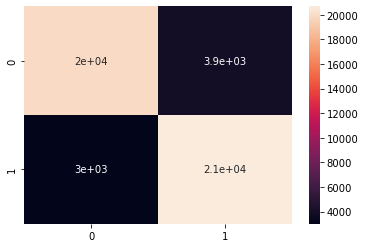

In [24]:
%%time
# Print confusion matrix
text1 = "Confusion Matrix for RandomForestClassifier"
text2 = """
Confusion Matrix is an N x N table (where N is the number of classes) visualisation, that contains 
the number of correct and incorrect predictions of the classification model. It is used to judge the 
performance of Classification Machine Learning Algorithms. It represents the summary of the predictions 
performed by the classification models."""
text3 = """
The diagonal from the top left to the bottom right contains the observations correctly predicted.
TRUE NEGATIVE (TN): The values which are actually negative and also predicted as negative.
FALSE NEGATIVE (FN): The values which are actually positive but predicted as negative.
FALSE POSITIVE (FP): The values which are actually negative but predicted as positive.
TRUE POSITIVE (TP): The values which are actually positive and predicted as positive too.
"""

print(text1, text2, text3, sep = '\n')
print(confusion_matrix(y_test,predictions), sep = '\n')
print(sns.heatmap(confusion_matrix(y_test, predictions), annot = True))

In [25]:
%%time
# Print Classification Report (prediction results)
text1 = "Classification Report (prediction results) for RandomForestClassifier"
text2 = """
The Classification Report is a numerical returns information on the accuracy level, precision rate, recall and 
F1-score for each class.

It is important to keep in mind whether the dataset is class balanced when using accuracy to evaluate a 
classification model, as it is easily informative when the classes are balanced but it can be misleading when the 
classes are unbalanced.
For example, if in a dataset only 5% of the observations are positive, and the accuracy is 90%, then this means 
that a model which returns false for ever sample will have a accuracy of 95%, but it will be of no use.
"""
text3 = """
Classification Metrics
Accuracy — It is defined as the value which shows the percentage of successful prediction from the input provided.
Accuracy = TP + TN / (TP + TN + FP + FN)

Precision score — It is the value that defines the set of values that are rightly predicted as True and also 
happens to be True in the actual set. By precision, we mean to understand that the positive values are indeed 
predicted as positive.
Precision = TP / (TP + FP)

Recall score — It is the value that represents a set of values that are actually True and also predicted correctly 
as True, By recall, we mean to understand that the particular class of samples is correctly predicted.
Recall = TP / (TP +FN)

F1 score
F1 score helps us rate the accuracy and efficiency of the model when the data is imbalanced. It is actually the 
harmonic mean of Precision and Recall scores.
F1 = 2*(Recall * Precision) / (Recall + Precision)

"""

print(text1, text2, text3)
print(classification_report(y_test, predictions))

Classification Report (prediction results) for RandomForestClassifier 
The Classification Report is a numerical returns information on the accuracy level, precision rate, recall and 
F1-score for each class.

It is important to keep in mind whether the dataset is class balanced when using accuracy to evaluate a 
classification model, as it is easily informative when the classes are balanced but it can be misleading when the 
classes are unbalanced.
For example, if in a dataset only 5% of the observations are positive, and the accuracy is 90%, then this means 
that a model which returns false for ever sample will have a accuracy of 95%, but it will be of no use.
 
Classification Metrics
Accuracy — It is defined as the value which shows the percentage of successful prediction from the input provided.
Accuracy = TP + TN / (TP + TN + FP + FN)

Precision score — It is the value that defines the set of values that are rightly predicted as True and also 
happens to be True in the actual set. 

AUC graph for RandomForestClassifier - Default Parameters 
When input data is highly skewed, any model can reach good accuracy by always predicting the same class. 
In our particular case, we are trying to predict the minority class well for the model to be useful.

Therefore the most relevant metric is AUC, or Area Under the Curve:

If AUC=50% the model is useless as it is wrong 50% of the time.
If AUC=100% the model is perfect, it identifies both classes right every time.
 
ROC stands for Receiver Operating Characteristic curve. This is a graph that shows the performance of a 
machine learning model on a classification problem by plotting the true positive rate and the false positive  
rate. AUC stands for Area Under the Curve. It is used to measure the entire area under the ROC curve.

The ROC curve plots the true positive rate and the false positive rate at different classification thresholds, 
whereas the AUC shows an aggregate measure of the performance of a machine learning mode

/opt/anaconda3/envs/ML_DS_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 2.35 s, sys: 52.5 ms, total: 2.4 s
Wall time: 3.16 s


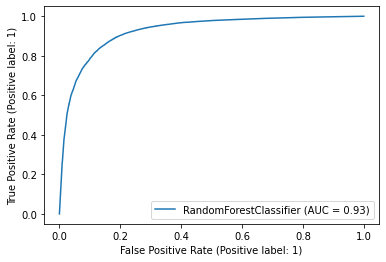

In [26]:
%%time
# Visual Outputs
text1 = "AUC graph for RandomForestClassifier - Default Parameters"
text2 = """
When input data is highly skewed, any model can reach good accuracy by always predicting the same class. 
In our particular case, we are trying to predict the minority class well for the model to be useful.

Therefore the most relevant metric is AUC, or Area Under the Curve:

If AUC=50% the model is useless as it is wrong 50% of the time.
If AUC=100% the model is perfect, it identifies both classes right every time.
"""
text3 = """
ROC stands for Receiver Operating Characteristic curve. This is a graph that shows the performance of a 
machine learning model on a classification problem by plotting the true positive rate and the false positive  
rate. AUC stands for Area Under the Curve. It is used to measure the entire area under the ROC curve.

The ROC curve plots the true positive rate and the false positive rate at different classification thresholds, 
whereas the AUC shows an aggregate measure of the performance of a machine learning model across all the possible 
classification thresholds.

"""

print(text1, text2, text3,)

plot_roc_curve(rfc, X_test, y_test) # Show AUC graph

In [27]:
#### As this result AUC is very high, we won't bother varying the parameters to try a better result.

In [28]:
# %%time # This Step may take a while, relative to the number of estimators... e.g. with 300 total trees calculated, 3 times as long as default. so 15 mins?
# ## Determine if better parameters can be found.
# # Define Model hyperparameter range (i.e. any parmeter to be varied)
# # Note, each RandomForest generates 
# params_to_test = {'n_estimators':[50, 100, 150]} # n_estimators is the number of trees in the forest
                  
# grid_search = GridSearchCV(estimator = rfc, param_grid=params_to_test, n_jobs=1) # Specify the CV parameters. n_jobs=-1 uses all cores.                           

# # fitting the model for grid search
# grid_search.fit(X_train, y_train)

# # Run RandomForestClassifier with determined best parameters.
# rfc_best_model = grid_search.best_estimator_ # This is already the best model, stored in the estimator. No need to rerun.

# print("Best parameters tested were:")
# # best_params = grid_search.best_params_ # Best parameters for model as a dict.
# # best_model = RandomForestClassifier(**best_params) #best_params is a dict you can pass directly to train a model with optimal settings

# # Print prediction results 
# predictions = rfc_best_model.predict(X_test) 
# print(classification_report(y_test, predictions))

# plot_roc_curve(rfc, X_test, y_test) # Show AUC graph

In [29]:
### Model Analysis - Fill in after running model

"""
Why use a Random Forest model?
Because there are numerous reasons for a flight not arriving on time, many of which cannot be predicted with any 
accuracy in the weeks or months before, such as when a person may be planning and booking a flight, we cannot 
easily with proper accuracy determine the required parameters and weightings the various inderpendant variables 
may have in their effect on the dependant variable.

In statistical machine learning, of which Decision Tree Classifiers and KN-N algorithms are a part of, the model 
is data-driven, in there is no predefined data model or structure assumed before fitting into data. This is then 
well suited to working with pure data and unknown connections that are present in the flight datasets. Likewise, 
because a person willnot know the previous states of the flights and airplanes before their flight, typical 
regression models can struggle.

In short, for this type of machine learned data, the tree model has two appealing aspects: 
 - Tree models provide a visual tool for exploring the data, to gain an idea of what variables are important and 
how they relate to one another. Trees can capture nonlinear relationships among predictor variables.

 - Tree models provide a set of rules that can be effectively communicated to non‐ specialists, either for 
implementation or to “sell” a data mining project.


Why not use Single Tree?
Due to the high level of unbalance in our data, using single tree would most likely lead to a biased outcome. 
Random Forest, by running many single trees and using the averages, helps to minimise this risk.



Why use AUC?
ROC stands for Receiver Operating Characteristic curve. This is a graph that shows the performance of a 
machine learning model on a classification problem by plotting the true positive rate and the false positive  
rate. AUC stands for Area Under the Curve. It is used to measure the entire area under the ROC curve.

The ROC curve plots the true positive rate and the false positive rate at different classification thresholds, 
whereas the AUC shows an aggregate measure of the performance of a machine learning model across all the possible 
classification thresholds.

In this case, the cost of a False Positive or a True Negative is not critical, so this is a useful way of judging
the model for many people, any of whom may have a different degree of care as to whether a flight arrives on time 
or not.


What about Entropy, Gini index, or F1 Score?
------------- to be written ------------------

"""

'\nWhy use a Random Forest model?\nBecause there are numerous reasons for a flight not arriving on time, many of which cannot be predicted with any \naccuracy in the weeks or months before, such as when a person may be planning and booking a flight, we cannot \neasily with proper accuracy determine the required parameters and weightings the various inderpendant variables \nmay have in their effect on the dependant variable.\n\nIn statistical machine learning, of which Decision Tree Classifiers and KN-N algorithms are a part of, the model \nis data-driven, in there is no predefined data model or structure assumed before fitting into data. This is then \nwell suited to working with pure data and unknown connections that are present in the flight datasets. Likewise, \nbecause a person willnot know the previous states of the flights and airplanes before their flight, typical \nregression models can struggle.\n\nIn short, for this type of machine learned data, the tree model has two appeali